In [ ]:
!pip install shap

In [9]:
# Data manipulation & analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Explainability
import shap

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set(style="whitegrid")


In [13]:
# Load your dataset, update the path if needed
df = pd.read_csv(r'/Users/aymenberkani/Downloads/creditcard.csv')

# Quick overview
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check data types and missing values
print(df.info())
print(df.isnull().sum())


Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

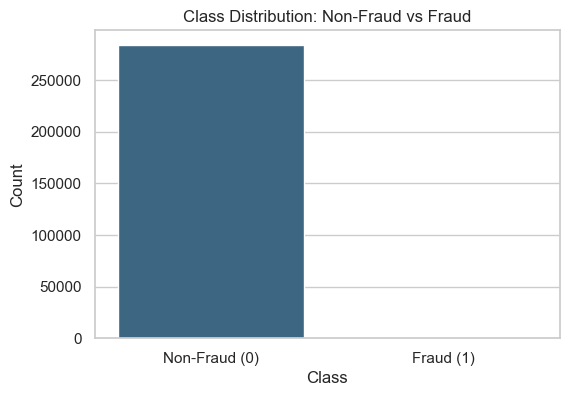

In [15]:
# Describe numerical features
print(df.describe())

# Check fraud vs non-fraud distribution
fraud_count = df['Class'].value_counts()
print(fraud_count)

# Visualize class imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_count.index, y=fraud_count.values, palette="viridis")
plt.title('Class Distribution: Non-Fraud vs Fraud')
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.show()


In [19]:
# Features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Scale the 'Amount' and 'Time' features (others are PCA transformed)
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])


In [21]:
# Stratified split to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Apply SMOTE to oversample minority class in training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE oversampling:")
print(f"X_train_res shape: {X_train_res.shape}")
print(f"y_train_res distribution:\n{y_train_res.value_counts()}")


Train shape: (227845, 30), Test shape: (56962, 30)
After SMOTE oversampling:
X_train_res shape: (454902, 30)
y_train_res distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



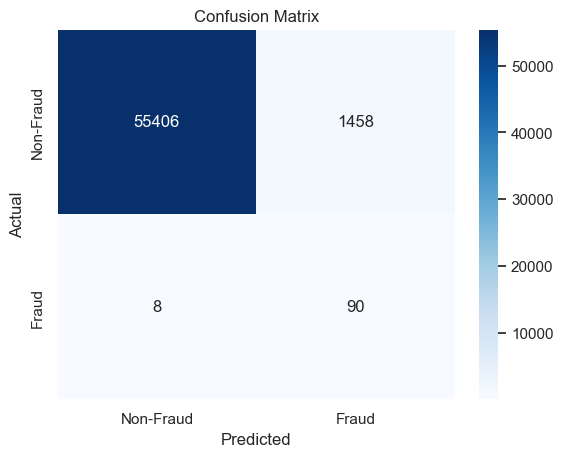

ROC AUC Score: 0.9698


In [23]:
# Initialize model
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train model
lr.fit(X_train_res, y_train_res)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


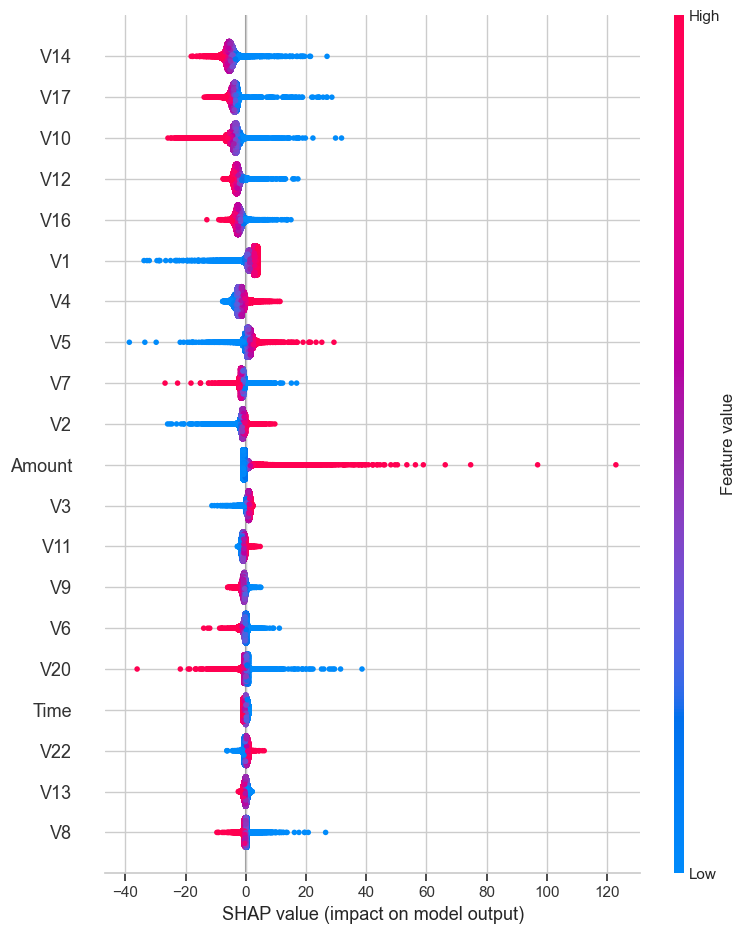

In [33]:
# SHAP values for logistic regression
explainer = shap.LinearExplainer(lr, X_train_res, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [ ]:
#ross-Validation for Robust Performance

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr, X_resampled, y_resampled, cv=skf, scoring='roc_auc')

print("Cross-Validated AUC Scores:", scores)
print("Mean AUC:", scores.mean())


Cross-Validated AUC Scores: [0.99166151 0.99151359 0.99160702 0.99150442 0.99146548]
Mean AUC: 0.9915504042438069


In [43]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)
print("Random Forest AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, rf_pred))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
xgb_pred = xgb.predict(X_test)
print("XGBoost AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, xgb_pred))


Random Forest AUC: 0.9731024901519414
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost AUC: 0.9791588308086319
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [49]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression on balanced data
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)
lr_pred = lr.predict(X_test)


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Random Forest": (rf_pred, rf.predict_proba(X_test)[:, 1]),
    "XGBoost": (xgb_pred, xgb.predict_proba(X_test)[:, 1]),
    "Logistic Regression": (lr.predict(X_test), lr.predict_proba(X_test)[:, 1])
}

print("🔎 Model Performance Summary:\n")
for name, (y_pred, y_prob) in models.items():
    print(f"📌 {name}")
    print(f"AUC Score:      {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Accuracy:       {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision:      {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:         {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:       {f1_score(y_test, y_pred):.4f}")
    print("-" * 40)


🔎 Model Performance Summary:

📌 Random Forest
AUC Score:      0.9731
Accuracy:       0.9995
Precision:      0.8454
Recall:         0.8367
F1 Score:       0.8410
----------------------------------------
📌 XGBoost
AUC Score:      0.9792
Accuracy:       0.9992
Precision:      0.7311
Recall:         0.8878
F1 Score:       0.8018
----------------------------------------
📌 Logistic Regression
AUC Score:      0.9698
Accuracy:       0.9743
Precision:      0.0581
Recall:         0.9184
F1 Score:       0.1094
----------------------------------------


In [ ]:
# Feature Importance (Random Forest + XGBoost)

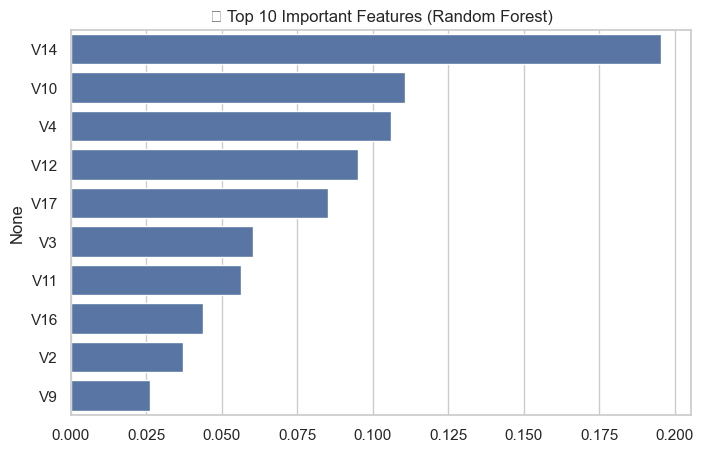

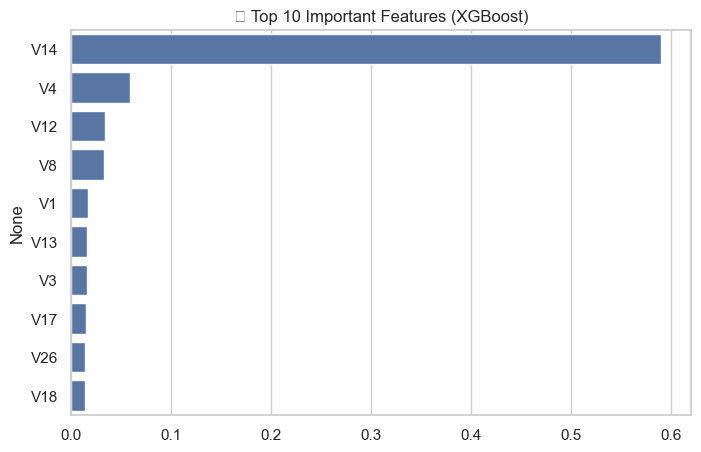

In [53]:
# For Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_rf = rf_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_rf.values, y=top_rf.index)
plt.title("🔍 Top 10 Important Features (Random Forest)")
plt.show()

# For XGBoost
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
top_xgb = xgb_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_xgb.values, y=top_xgb.index)
plt.title("🔍 Top 10 Important Features (XGBoost)")
plt.show()

In [ ]:
#Refine Dataset Based on Feature Importance

In [55]:
top_features = ['V14', 'V10', 'V4', 'V12', 'V17', 'V3', 'V11', 'V16', 'V2', 'V9']  # From RF
X_top = X[top_features]


In [ ]:
#To go deeper than just feature importance and understand how each feature affects predictions

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Use top features identified earlier
top_features = ['V14', 'V10', 'V4', 'V12', 'V17', 'V3', 'V11', 'V16', 'V2', 'V9']
X_top = X[top_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, stratify=y, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

100%|===================| 56872/56962 [02:43<00:00]        

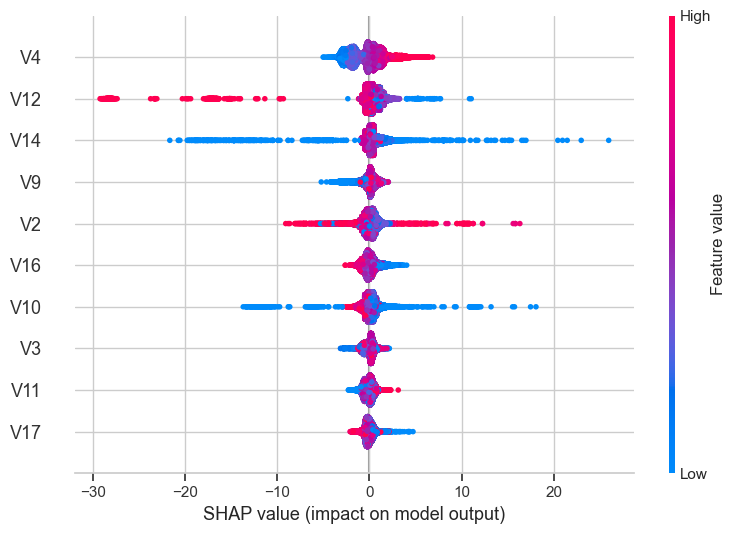

In [65]:
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary Plot (Feature Impact Visualization)
shap.summary_plot(shap_values, X_test)
